Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 0.3157 - val_loss: 0.1591
Epoch 2/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.2257 - val_loss: 0.0832
Epoch 3/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.1250 - val_loss: 0.0394
Epoch 4/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.0560 - val_loss: 0.0248
Epoch 5/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.0361 - val_loss: 0.0354
Epoch 6/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.0424 - val_loss: 0.0583
Epoch 7/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.0625 - val_loss: 0.0780
Epoch 8/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.0802 - val_loss: 0.0853
Epoch 9/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0548 - val_loss: 0.0853
Epoch 10/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.1005 - val_loss: 0.0747
Epoch 11/10

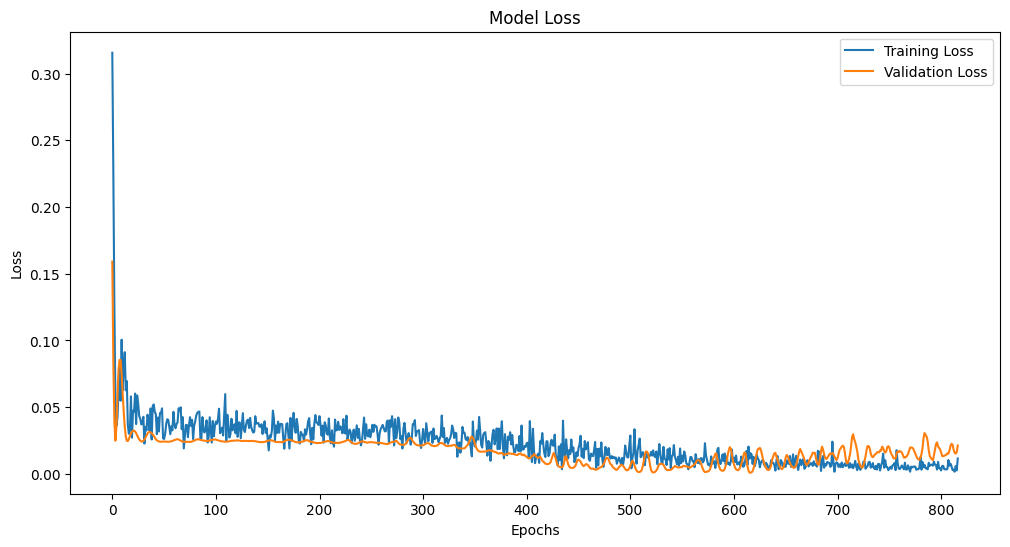

1/1 [==============================] - 0s 24ms/step


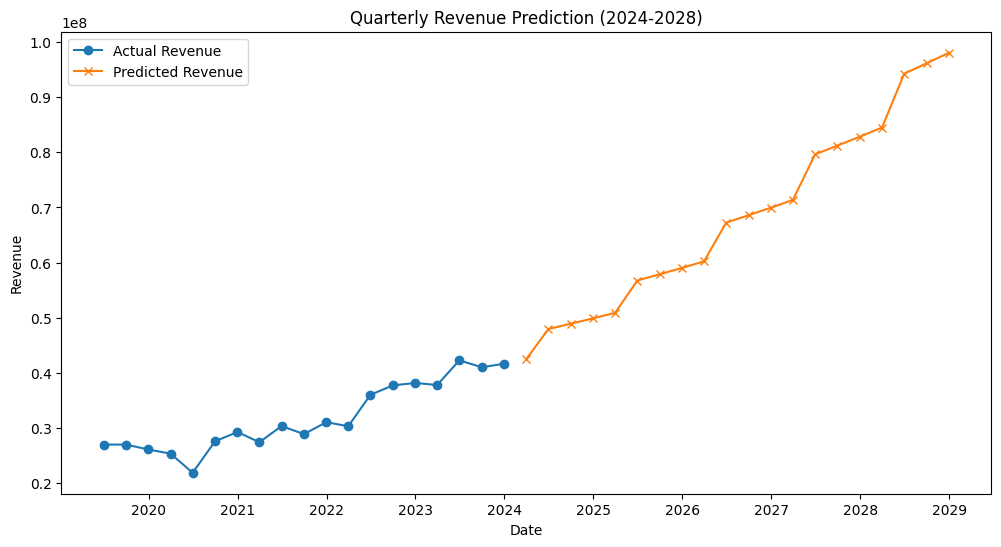

           ds          yhat
0  2024-03-31  4.246518e+07
1  2024-06-30  4.794242e+07
2  2024-09-30  4.890126e+07
3  2024-12-31  4.987929e+07
4  2025-03-31  5.087687e+07
5  2025-06-30  5.673807e+07
6  2025-09-30  5.787283e+07
7  2025-12-31  5.903029e+07
8  2026-03-31  6.021090e+07
9  2026-06-30  6.724568e+07
10 2026-09-30  6.859060e+07
11 2026-12-31  6.996241e+07
12 2027-03-31  7.136166e+07
13 2027-06-30  7.962662e+07
14 2027-09-30  8.121915e+07
15 2027-12-31  8.284354e+07
16 2028-03-31  8.450041e+07
17 2028-06-30  9.426697e+07
18 2028-09-30  9.615231e+07
19 2028-12-31  9.807536e+07


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# 데이터 로드 및 준비
file_path = '기업정보.xlsx'
data = pd.read_excel(file_path, header=1, sheet_name='005380')


# 매출액 데이터 추출 및 전처리
sales = data['매출액'][::-1].dropna().values
dates = pd.date_range(start='2019-01-01', periods=len(sales), freq='Q')
df = pd.DataFrame({'ds': dates, 'y': sales})
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 분기 정보를 추가하여 계절성을 반영
df['quarter'] = df.index.quarter

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 8  # 시퀀스 길이 조정
X, y = [], []

for i in range(len(df) - sequence_length):
    X_seq = df['growth_rate'].values[i:i + sequence_length]
    quarter_seq = df['quarter'].values[i:i + sequence_length]
    X.append(np.column_stack((X_seq, quarter_seq)))
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# 모델 생성
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 2)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# EarlyStopping 콜백 추가
early_stop = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('lstm_model.h5', monitor='val_loss', save_best_only=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=16, callbacks=[early_stop, model_checkpoint])

# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 로드
loaded_model = tf.keras.models.load_model('lstm_model.h5')

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = np.column_stack((df['growth_rate'].values[-sequence_length:], df['quarter'].values[-sequence_length:])).reshape((1, sequence_length, 2))

base_growth_rate = 0.02  # 최소 성장률 5% 설정

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = loaded_model.predict(current_sequence)
    # 최소 성장률을 설정하여 매출이 항상 증가하도록 보장
    adjusted_growth_rate = max(predicted_growth_rate[0, 0], base_growth_rate)
    future_growth_rates.append(adjusted_growth_rate)
    next_sequence = np.append(current_sequence[0, 1:], [[adjusted_growth_rate, (current_sequence[0, -1, 1] % 4) + 1]], axis=0)
    current_sequence = next_sequence.reshape((1, sequence_length, 2))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    # 최소 5% 성장을 보장
    next_revenue = max(next_revenue, last_revenue * (1 + base_growth_rate))
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])


In [4]:
### import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf

import warnings
warnings.filterwarnings(action='ignore')

In [5]:
### DB에서 재무데이터 불러오기 
def load_FS():

        company = input("종목코드를 입력하세요: ")
        table = pd.read_excel('기업정보.xlsx', header=1, sheet_name=company)
        table = table.iloc[:,1:]

        return company, table

In [6]:
### 과거 5개년치 분기별 FCFF데이터 전처리
class step1:
    
    def __init__(self, company, table):
        self._company = company
        self._table = table
        self._tax = 0
        self._sales = [] 
        self._cogs = []
        self._sgna = []
        self._op = []
        self._capex_l = []
        self._dep_l = []
        self._amo_l = []
        self._dNWC = [0]
        self._FCFF = []
        self._NWC = [] 
    
    def Basic_IS(self):
        
        self._sales = self._table['매출액'][::-1].dropna().values / 100 
        self._cogs = self._table['매출원가'][::-1].dropna().values / 100
        self._sgna = self._table['판매관리비'][::-1].dropna().values / 100
        self._tax = self._table['법인세율'][::-1].dropna().values / 100 

        for i in range(20):
            self._op.append((self._sales[i]-self._cogs[i]-self._sgna[i])*(1-self._tax[i]))

        return self._tax
    
    def Basic_CF(self):

        self._capex_l = self._table['자본적지출'][::-1].dropna().values / 100
        self._dep_l = self._table['유형자산감가상각비'][::-1].dropna().values / 100
        self._amo_l = self._table['무형자산감가상각비'][::-1].dropna().values / 100
    
    def Dnwc(self):

        self._NWC = self._table['순운전자본'][::-1].dropna().values[1:] / 100
        self._dNWC = self._table['순운전자본증감'][::-1].dropna().values / 100
 
    def FCFF(self):
    
        for i in range(20):
            self._FCFF.append(self._op[i]+self._dep_l[i]+self._amo_l[i]-self._capex_l[i]-self._dNWC[i])

    def mktable(self):
        
        d_main_info = {'매출액': self._sales,'매출원가': self._cogs,'판관비': self._sgna
                 ,'영업이익': self._op,'+유형자산상각비':self._dep_l,'+무형자산상각비': self._amo_l,
                   '-Capex': self._capex_l,'-dNwc': self._dNWC, 'FCFF': self._FCFF, '참고용NWC': self._NWC}
        
      
        # 2019년 1분기부터 2023년 4분기까지의 분기 생성
        quarters = []
        for year in range(2019, 2024):
            for q in range(1, 5):
                quarters.append(f"{year}-Q{q}")

        # 각 리스트의 길이가 20인지 확인
        for key, value in d_main_info.items():
            if len(value) != 20:
                raise ValueError(f"{key} 리스트의 길이가 20이 아닙니다. 현재 길이: {len(value)}")

        Main_info = pd.DataFrame(d_main_info, index=quarters)

        S_BS = Main_info.transpose()
        print("최근 5개년 분기별 FCFF(단위: 억)")
        display(S_BS)
        print("첫 번째 열의 dNWC의 경우 해당 페이지에서 얻을 수 없으며, 미래 추정에 영향을 주지 않음\n ")
        return S_BS


In [8]:
# Step1 : loading F/S
FS1_tables = load_FS()
company = FS1_tables[0]
table = FS1_tables[1]

asset1 = step1(company, table)
tax = asset1.Basic_IS()
asset1.Basic_CF()
asset1.Dnwc()
asset1.FCFF()
fcff_table = asset1.mktable()

최근 5개년 분기별 FCFF(단위: 억)


,2019-Q1,2019-Q2,2019-Q3,2019-Q4,2020-Q1,2020-Q2,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,2022-Q1,2022-Q2,2022-Q3,2022-Q4,2023-Q1,2023-Q2,2023-Q3,2023-Q4
매출액,239870.790000,269663.530000,269688.530,260753.160000,253194.4800,218589.910000,275758.120000,292433.500000,273908.710000,303260.660000,288672.200000,310264.6900,302985.68000,359998.96000,377054.420000,381475.630000,377786.930000,422496.950000,410026.630000,416325.2800
매출원가,200744.170000,223433.130000,225404.670,205577.340000,210541.3800,181471.640000,224505.450000,238640.840000,223543.010000,245947.970000,236335.340000,250974.9900,245253.62000,285995.92000,303482.510000,304063.640000,300566.800000,333563.090000,325413.050000,332248.8900
판관비,30877.910000,33853.150000,40498.660,55640.270000,34015.3400,31215.060000,54390.900000,41248.690000,33799.550000,38452.680000,36270.130000,43993.1000,38442.76000,44205.10000,58053.720000,43768.140000,41293.140000,46554.550000,46395.590000,49331.6700
영업이익,8228.088225,12346.306875,3775.737,-463.288875,8616.1656,5888.451975,-3130.384425,12512.610075,16524.734625,18812.859975,16026.563175,15258.3585,19241.07675,29723.44515,15479.394525,33559.740375,35837.172525,42273.361725,38122.445025,34657.8582
+유형자산상각비,6027.580000,6261.930000,6436.120,8666.220000,6602.8700,6731.100000,7002.030000,7055.850000,6984.980000,7022.850000,7422.080000,7895.2500,7622.61000,7902.66000,7536.790000,8690.790000,8014.120000,8218.940000,8153.290000,8396.9300
+무형자산상각비,3143.670000,3219.450000,3252.060,4743.420000,3461.2000,3631.590000,3633.570000,3632.240000,3859.980000,3750.780000,3946.370000,4621.1000,4329.54000,4510.24000,4424.740000,5404.830000,4476.850000,4158.530000,4089.520000,3902.7500
-Capex,5449.620000,7609.450000,8946.710,24701.700000,6667.3200,12863.870000,9915.350000,17260.940000,6745.530000,9245.260000,10959.660000,16877.2900,6293.12000,8206.24000,8591.640000,20476.010000,6323.990000,16572.820000,16497.040000,31272.3800
-dNwc,16382.200000,14942.110000,-50916.890,11583.480000,-7520.8200,27953.440000,-7637.990000,1785.890000,-2126.020000,30726.950000,10113.310000,-37696.7400,-178.66000,-4390.03000,-3785.960000,-13403.130000,27842.040000,6358.750000,21502.590000,6394.7500
FCFF,-4432.481775,-723.873125,55434.097,-23338.828875,19533.7356,-24566.168025,5227.855575,4153.870075,22750.184625,-10385.720025,6322.043175,48594.1585,25078.76675,38320.13515,22635.244525,40582.480375,14162.112525,31719.261725,12365.625025,9290.4082
참고용NWC,252079.070000,267021.180000,216104.290,227687.770000,220166.9500,248120.390000,240482.400000,242268.290000,240142.270000,270869.220000,280982.530000,243285.7900,243107.13000,238717.10000,234931.140000,221528.010000,249370.050000,255728.800000,277231.390000,283626.1400


첫 번째 열의 dNWC의 경우 해당 페이지에서 얻을 수 없으며, 미래 추정에 영향을 주지 않음
 


In [9]:
### 5개년치 추정
class step2:

    def __init__(self, table, tax):
        
        self._table = table.transpose()
        self._tax = tax
        self._pred_sales = []
        self._cagr =  0
        self._cogs_avg = 0
        self._sgna_avg = 0
        self._capex_ratio = 0
        self._dep_ratio = 0
        self._amo_ratio = 0
        self._NWC_ratio = 0


    def salesForcast(self):
       
        import pandas as pd
        import numpy as np
        from sklearn.preprocessing import MinMaxScaler
        from sklearn.model_selection import train_test_split
        import tensorflow as tf
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout
        from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
        import matplotlib.pyplot as plt


        # 매출액 데이터 추출 및 전처리
        sales = self._table['매출액'].values 
        dates = pd.date_range(start='2019-01-01', periods=len(sales), freq='Q')
        df = pd.DataFrame({'ds': dates, 'y': sales})
        df.set_index('ds', inplace=True)

        # 성장률 계산
        df['growth_rate'] = df['y'].pct_change()

        # 분기 정보를 추가하여 계절성을 반영
        df['quarter'] = df.index.quarter

        # 성장률 예측을 위한 데이터 준비
        df.dropna(inplace=True)  # NaN 값 제거
        scaler = MinMaxScaler()
        df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

        sequence_length = 8  # 시퀀스 길이 조정
        X, y = [], []

        for i in range(len(df) - sequence_length):
            X_seq = df['growth_rate'].values[i:i + sequence_length]
            quarter_seq = df['quarter'].values[i:i + sequence_length]
            X.append(np.column_stack((X_seq, quarter_seq)))
            y.append(df['growth_rate'].values[i + sequence_length])

        X = np.array(X)
        y = np.array(y)
       
       
        # 모델 로드
        loaded_model = tf.keras.models.load_model('lstm_model.h5')

        # 2024년부터 2028년까지의 분기별 성장률 예측
        future_growth_rates = []
        current_sequence = np.column_stack((df['growth_rate'].values[-sequence_length:], df['quarter'].values[-sequence_length:])).reshape((1, sequence_length, 2))

        base_growth_rate = 0.02  # 최소 성장률 5% 설정

        for i in range(20):  # 5년 * 4분기 = 20분기 예측
            predicted_growth_rate = loaded_model.predict(current_sequence)
            # 최소 성장률을 설정하여 매출이 항상 증가하도록 보장
            adjusted_growth_rate = max(predicted_growth_rate[0, 0], base_growth_rate)
            future_growth_rates.append(adjusted_growth_rate)
            next_sequence = np.append(current_sequence[0, 1:], [[adjusted_growth_rate, (current_sequence[0, -1, 1] % 4) + 1]], axis=0)
            current_sequence = next_sequence.reshape((1, sequence_length, 2))

        # 예측된 성장률 반전 정규화
        future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

        # 예측된 성장률 기반으로 매출액 계산
        last_revenue = df['y'].values[-1]
        future_revenues = []

        for growth_rate in future_growth_rates.flatten():
            next_revenue = last_revenue * (1 + growth_rate)
            # 최소 5% 성장을 보장
            next_revenue = max(next_revenue, last_revenue * (1 + base_growth_rate))
            future_revenues.append(next_revenue)
            last_revenue = next_revenue

        # 예측 결과 데이터프레임 생성
        future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
        future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

        # 시각화
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
        plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
        plt.xlabel('Date')
        plt.ylabel('Revenue')
        plt.title('SK Hynix Quarterly Revenue Prediction (2024-2028)')
        plt.legend()
        plt.show()

        # 예측된 매출 출력
        print(future_df[['ds', 'yhat']])



        self.F_sales = future_df['yhat'].values


    def ratios(self):
        
        
        for i in range(20):
            self._cogs_avg += self._table['매출원가'][i] / self._table['매출액'][i]/20
            self._sgna_avg += self._table['판관비'][i] / self._table['매출액'][i]/20
            self._capex_ratio += self._table['-Capex'][i] / self._table['매출액'][i]/20
            self._dep_ratio += self._table['+유형자산상각비'][i] / self._table['매출액'][i]/20
            self._amo_ratio += self._table['+무형자산상각비'][i] / self._table['매출액'][i]/20
            self._NWC_ratio += self._table['참고용NWC'][i] / self._table['매출액'][i]/20

        print("매출원가", self._cogs_avg)
        print("판관비", self._sgna_avg)
        print("자본적지출", self._capex_ratio)
        print("유형상각", self._dep_ratio)
        print("무형상각", self._amo_ratio)
        print("순운전자본", self._NWC_ratio)
        '''
        # 중앙값이 좋을 것 같음..!
        self._cogs_avg = np.median(self._table['매출원가'][i] / self._table['매출액'][i])
        self._sgna_avg = np.median(self._table['판관비'][i] / self._table['매출액'][i])
        self._capex_ratio = np.median(self._table['-Capex'][i] / self._table['매출액'][i])
        self._dep_ratio = np.median(self._table['+유형자산상각비'][i] / self._table['매출액'][i])
        self._amo_ratio = np.median(self._table['+무형자산상각비'][i] / self._table['매출액'][i])
        self._NWC_ratio = np.median(self._table['참고용NWC'][i] / self._table['매출액'][i])

        print("매출원가", self._cogs_avg)
        print("판관비", self._sgna_avg)
        print("자본적지출", self._capex_ratio)
        print("유형상각", self._dep_ratio)
        print("무형상각", self._amo_ratio)
        print("순운전자본", self._NWC_ratio)
        '''
    def forecast(self):
        
        F_sales = self.F_sales
        F_cogs = []
        F_sgna = []
        F_op = []
        F_capex = []
        F_dep = []
        F_amo = []
        F_dnwc = []
        F_FCFF = []
        F_NWC = []

        last_NWC = self._table['참고용NWC'][-1] / 100  # 2023-Q4의 순운전자본
        print(last_NWC)

        for i in range(20):
            F_cogs_val = np.round(F_sales[i] * self._cogs_avg, 1)
            F_sgna_val = np.round(F_sales[i] * self._sgna_avg, 1)
            F_op_val = np.round((F_sales[i] - F_cogs_val - F_sgna_val) * (1 - self._tax), 1)
            F_capex_val = np.round(F_sales[i] * self._capex_ratio, 1)
            F_dep_val = np.round(F_sales[i] * self._dep_ratio, 1)
            F_amo_val = np.round(F_sales[i] * self._amo_ratio, 1)
            F_NWC_val = np.round(F_op_val * self._NWC_ratio, 1)

            if i == 0:
                F_dnwc_val = np.round(F_NWC_val - last_NWC, 1)
            else:
                F_dnwc_val = np.round(F_NWC_val - F_NWC[i-1], 1)

            F_FCFF_val = np.round(F_op_val + F_dep_val + F_amo_val - F_capex_val - F_dnwc_val, 1)

            F_cogs.append(F_cogs_val)
            F_sgna.append(F_sgna_val)
            F_op.append(F_op_val)
            F_capex.append(F_capex_val)
            F_dep.append(F_dep_val)
            F_amo.append(F_amo_val)
            F_NWC.append(F_NWC_val)
            F_dnwc.append(F_dnwc_val)
            F_FCFF.append(F_FCFF_val)
        
        F_op = [np.mean(arr) for arr in F_op]
        F_dnwc = [np.mean(arr) for arr in F_dnwc]
        F_FCFF = [np.mean(arr) for arr in F_FCFF]

        dFIS = {
            '매출액': F_sales,
            '매출원가': F_cogs,
            '판관비': F_sgna,
            '영업이익': F_op,
            '+유형자산상각비': F_dep,
            '+무형자산상각비': F_amo,
            '-Capex': F_capex,
            '-dNwc': F_dnwc,
            'FCFF': F_FCFF
        }
        
        # 2024년 1분기부터 2028년 4분기까지의 분기 생성
        quarters = []
        for year in range(2024, 2029):
            for q in range(1, 5):
                quarters.append(f"{year}-Q{q}")

        # 각 리스트의 길이가 20인지 확인
        for key, value in dFIS.items():
            if len(value) != 20:
                raise ValueError(f"{key} 리스트의 길이가 20이 아닙니다. 현재 길이: {len(value)}")

        ISFt = pd.DataFrame(dFIS, index=quarters)

        FIS = ISFt.transpose()
        print("미래 5개년 분기별 FCFF(단위: 억)")
        display(FIS)
        print("첫 번째 열의 dNWC의 경우 해당 페이지에서 얻을 수 없으며, 미래 추정에 영향을 주지 않음\n ")
        return FIS


1/1 [==============================] - 0s 22ms/step


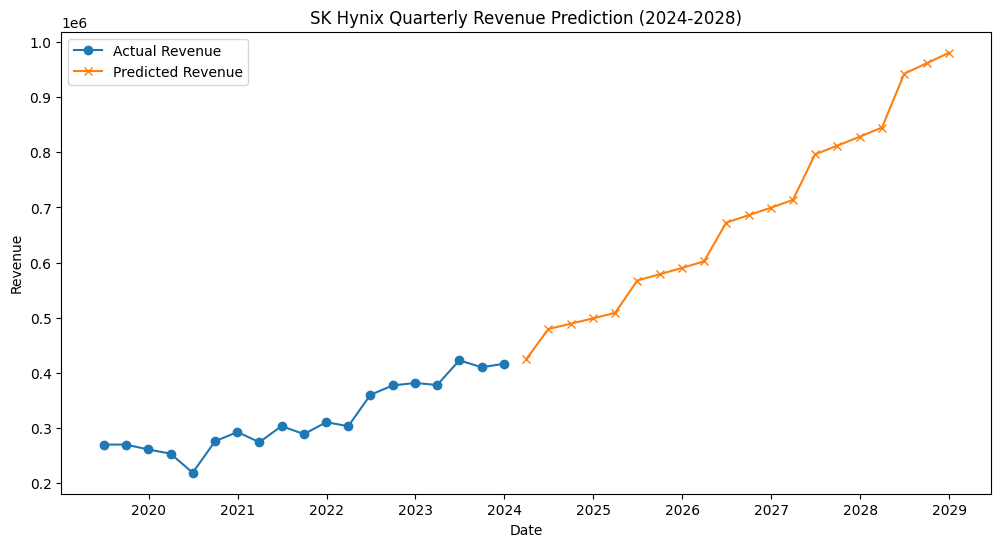

           ds           yhat
0  2024-03-31  424651.785600
1  2024-06-30  479424.155791
2  2024-09-30  489012.638907
3  2024-12-31  498792.891685
4  2025-03-31  508768.749518
5  2025-06-30  567380.724164
6  2025-09-30  578728.338648
7  2025-12-31  590302.905421
8  2026-03-31  602108.963529
9  2026-06-30  672456.847652
10 2026-09-30  685905.984605
11 2026-12-31  699624.104297
12 2027-03-31  713616.586383
13 2027-06-30  796266.222500
14 2027-09-30  812191.546950
15 2027-12-31  828435.377889
16 2028-03-31  845004.085447
17 2028-06-30  942669.733178
18 2028-09-30  961523.127842
19 2028-12-31  980753.590399
매출원가 0.8109468440296184
판관비 0.13601996948312742
자본적지출 0.039891263884581
유형상각 0.02411298979384955
무형상각 0.012998150500057154
순운전자본 0.8120097674496108
2836.2614000000003
미래 5개년 분기별 FCFF(단위: 억)


,2024-Q1,2024-Q2,2024-Q3,2024-Q4,2025-Q1,2025-Q2,2025-Q3,2025-Q4,2026-Q1,2026-Q2,2026-Q3,2026-Q4,2027-Q1,2027-Q2,2027-Q3,2027-Q4,2028-Q1,2028-Q2,2028-Q3,2028-Q4
매출액,424651.7856,479424.155791,489012.638907,498792.891685,508768.749518,567380.724164,578728.338648,590302.905421,602108.963529,672456.847652,685905.984605,699624.104297,713616.586383,796266.2225,812191.54695,828435.377889,845004.085447,942669.733178,961523.127842,980753.590399
매출원가,344370.0000,388787.500000,396563.300000,404494.500000,412584.400000,460115.600000,469317.900000,478704.300000,488278.400000,545326.800000,556233.300000,567358.000000,578705.100000,645729.6000,658644.20000,671817.100000,685253.400000,764455.000000,779744.100000,795339.000000
판관비,57761.1000,65211.300000,66515.500000,67845.800000,69202.700000,77175.100000,78718.600000,80293.000000,81898.800000,91467.600000,93296.900000,95162.800000,97066.100000,108308.1000,110474.30000,112683.800000,114937.400000,128221.900000,130786.300000,133402.100000
영업이익,22464.4000,25361.800000,25869.000000,26386.500000,26914.200000,30014.800000,30615.100000,31227.300000,31851.900000,35573.300000,36284.800000,37010.500000,37750.800000,42123.0000,42965.40000,43824.600000,44701.300000,49867.900000,50865.200000,51882.500000
+유형자산상각비,10239.6000,11560.300000,11791.600000,12027.400000,12267.900000,13681.200000,13954.900000,14234.000000,14518.600000,16214.900000,16539.200000,16870.000000,17207.400000,19200.4000,19584.40000,19976.100000,20375.600000,22730.600000,23185.200000,23648.900000
+무형자산상각비,5519.7000,6231.600000,6356.300000,6483.400000,6613.100000,7374.900000,7522.400000,7672.800000,7826.300000,8740.700000,8915.500000,9093.800000,9275.700000,10350.0000,10557.00000,10768.100000,10983.500000,12253.000000,12498.000000,12748.000000
-Capex,16939.9000,19124.800000,19507.300000,19897.500000,20295.400000,22633.500000,23086.200000,23547.900000,24018.900000,26825.200000,27361.700000,27908.900000,28467.100000,31764.1000,32399.30000,33047.300000,33708.300000,37604.300000,38356.400000,39123.500000
-dNwc,15405.0000,2352.700000,411.900000,420.200000,428.500000,2517.700000,487.500000,497.100000,507.200000,3021.800000,577.700000,589.300000,601.100000,3550.3000,684.00000,697.700000,711.900000,4195.300000,809.800000,826.100000
FCFF,5878.8000,21676.200000,24097.700000,24579.600000,25071.300000,25919.700000,28518.700000,29089.100000,29670.700000,30681.900000,33800.100000,34476.100000,35165.700000,36359.0000,40023.50000,40823.800000,41640.200000,43051.900000,47382.200000,48329.800000


첫 번째 열의 dNWC의 경우 해당 페이지에서 얻을 수 없으며, 미래 추정에 영향을 주지 않음
 


In [10]:
 # Step2 : Forecasting
asset1 = step2(fcff_table, tax)
asset1.salesForcast()
asset1.ratios()
forecast = asset1.forecast()

In [11]:
class WACC:
    
    print("\n__________________________________________________________________________________________")
    print("WACC는 가중평균 자본비용으로 미래 가치들에 대한 할인율로 이용된다.")
    
    def __init__(self, company, table, tax):
        
        self._company = company
        self._table = table
        self._tax = tax
        self._Rf = 0
        self._Rm = 0
        self._beta = 0
        self._kd = 0
        self._ke = 0 

    def risk_free_rate(self):
        
        # 연도별로 xlsx 업데이트 필요 (2019~2023)
        #'https://www.index.go.kr/unity/potal/main/EachDtlPageDetail.do?idx_cd=1073#'
        tables = pd.read_excel('2024국고채.xlsx')
        rf_r = tables.iloc[3:4, 4:9]
        b5y = rf_r.values.flatten().tolist()

        # 국고채 5년 수익률의 가중평균
        for i in range(len(b5y)):
            self._Rf += b5y[i]/len(b5y)

        self._Rf = round(self._Rf/100,4)
        print("Rf : 무위험 수익률")
        print("한국 국고채 5년 평균 수익률: {}%\n".format(str(round(self._Rf*100,3))))
        return self._Rf


    def market_risk_premium(self):

        KOSPI = yf.download('^KS11', start="2019-01-01",end="2023-12-31")['Adj Close']
        returns = KOSPI.pct_change()

        self._Rm = round(returns.mean() * 252, 3)

        print("Rm : 시장 수익률")
        print("KOSPI 5년 평균 수익률: {}%\n".format(str(round(self._Rm*100,3))))
        
        return self._Rm


        '''
        # 연도별로 xlsx 업데이트 필요 (2019~2023)
        #'https://finance.yahoo.com/quote/%5EKS11/history?frequency=1mo&period1=1557132568&period2=1714985072'
        
        tables = pd.read_csv('/Users/hw/서강대학부자료/Quantifi/금융보고서스터디/24코스피.csv')

        tables['pct_year'] = tables['Close'].pct_change()
        
        # 일별수익률의 평균을 구한 후 연수익률로 환산
        self._Rm = round(tables['pct_year'].mean() * 252, 3)
        
        print("Rm : 시장 수익률")
        print("KOSPI 5년 평균 수익률: {}%\n".format(str(round(self._Rm*100,3))))
        return self._Rm
        '''
        
    def beta(self):
        
        tickers = ['^KS11', self._company + '.KS']

        price = pd.DataFrame()
        for items in tickers:
            price[items] = yf.download(items, start="2019-01-01",end="2023-12-31")['Adj Close']

        returns = price.pct_change()
        
        covs = returns.cov()
        covs = covs.loc['^KS11', self._company + '.KS']

        import math
        var_KOSPI = returns['^KS11'].var()

        self._beta = covs / var_KOSPI
        
        print("Beta : 회사주가와 시장지수의 상관계수")
        print("Leverd Beta: {}\n".format(self._beta))
        
        
        print(">>>>Re(자기자본비용) = Rf + Beta(Rm-Rf)\n\n ")
        return self._beta

    # 신용등급을 직접입력하는...    
    '''
    def cost_debt(self):
        
        source_url = 'https://www.kisrating.com/ratingsStatistics/statics_spread.do'
        tables = pd.read_html(source_url, encoding='utf-8')
        self._kd_r = tables[0]
        self._kd_r.index = list(self._kd_r.iloc[:,0])
        self._kd_r = self._kd_r.drop(['구분','3월','6월','9월','1년','1년6월','2년','3년'],axis = 1)
        
        credit = input("회사신용등급입력: 국고채, AAA, AA+, AA, AA-, A+, A, A-, BBB+, BBB, BBB-")
        
        print(self._kd_r)

        self._kd = self._kd_r.loc[credit, '5년']/100
        
        print("Kd(타인자본비용)")
        print("{0} 등급 회사채 수익률: {1}%\n".format(credit, str(round(self._kd*100,3))))
              
        return self._kd
    '''

    # 신용등급을 크롤링해서 자동으로 회사채 이자율 설정
    def cost_debt(self):
        
        source_url = 'https://www.kisrating.com/ratingsStatistics/statics_spread.do'
        tables = pd.read_html(source_url, encoding='utf-8')
        self._kd_r = tables[0]
        self._kd_r.index = list(self._kd_r.iloc[:,0])
        self._kd_r = self._kd_r.drop(['구분','3월','6월','9월','1년','1년6월','2년','3년'],axis = 1)
        
        url = 'https://comp.fnguide.com/SVO2/asp/SVD_Main.asp?pGB=1&gicode=A{0}&cID=&MenuYn=Y&ReportGB=&NewMenuID=101&stkGb=701'.format(self._company)
        response = requests.get(url)
        html_content = response.content

        # BeautifulSoup 객체 생성
        soup = BeautifulSoup(html_content, 'html.parser')

        # KIS의 신용등급 정보를 포함하는 태그 파싱
        kis_rating_tag = soup.select_one('#svdMainGrid7 tbody tr.rwc_g td.clf.c')

        # 신용등급과 날짜를 추출
        grade, date = kis_rating_tag.text.split('[')
        date = date.strip(']')

        # 결과 저장
        kis_credit_rating = {'grade': grade.strip(), 'date': date}

        # 결과 출력
        print(kis_credit_rating)
        
        credit = grade.strip()

        print(self._kd_r)

        self._kd = self._kd_r.loc[credit, '5년']/100
        
        print("Kd(타인자본비용)")
        print("{0} 등급 회사채 수익률: {1}%\n".format(credit, str(round(self._kd*100,3))))
              
        return self._kd
    

    def wacc(self):
        
        equity_ratio = round(self._table.iloc[0,16]/self._table.iloc[0,15],4)
        debt_ratio = 1 - equity_ratio
        self._ke = self._Rf+self._beta*(self._Rm-self._Rf)

        print("Ke(자기자본비용): {}%\n".format(str(np.round(self._ke*100, 3))))

        wacc = self._kd*(1-self._tax[0])*debt_ratio + self._ke*equity_ratio
        print("WACC = ke*자본비율 + kd(1-tax)*부채비율")
        print("WACC(가중평균자본비용): {}%".format(str(np.round(wacc*100,2))))
        return wacc



__________________________________________________________________________________________
WACC는 가중평균 자본비용으로 미래 가치들에 대한 할인율로 이용된다.


In [12]:
# Step3 : WACC
asset1 = WACC(company, table, tax)
asset1.risk_free_rate()
asset1.market_risk_premium()
asset1.beta()
asset1.cost_debt()
wacc = asset1.wacc()

Rf : 무위험 수익률
한국 국고채 5년 평균 수익률: 2.29%



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Rm : 시장 수익률
KOSPI 5년 평균 수익률: 7.5%



[*********************100%%**********************]  1 of 1 completed


Beta : 회사주가와 시장지수의 상관계수
Leverd Beta: 1.0456454965465996

>>>>Re(자기자본비용) = Rf + Beta(Rm-Rf)

 
{'grade': 'AA+', 'date': '2024/03/18'}
        5년
국고채   3.06
AAA   3.42
AA+   3.45
AA    3.52
AA-   3.62
A+    4.44
A     4.89
A-    5.49
BBB+  7.44
BBB   8.49
BBB-  9.90
Kd(타인자본비용)
AA+ 등급 회사채 수익률: 3.45%

Ke(자기자본비용): 7.738%

WACC = ke*자본비율 + kd(1-tax)*부채비율
WACC(가중평균자본비용): 4.99%


In [13]:
class DCF:
    
    def __init__(self, table, forecast, wacc, company):
        
        self._table = table
        self._forecast = forecast
        self._wacc = wacc
        self._company = company
        self._stockvalue = 0
        
        self._pv_FCFF = 0
        self._TV = 0
        self._pv_TV = 0
        self._net_NOA = 0
        self._Pg = 0
        self._TV_t = 0
        self._PVTV_t = 0
        self._pvfcff_t = 0
        self._stock_value_t = 0
        
        
    def pv_FCFF(self):
        
        sen_t = []
        index = []

        # 연간 WACC를 분기 할인율로 변환
        quarterly_wacc = (1 + self._wacc) ** (1/4) - 1

        # 분기별 할인 적용
        for i in range(len(self._forecast.loc['FCFF'])):
            self._pv_FCFF += self._forecast.loc['FCFF'][i] / ((1 + quarterly_wacc) ** (i + 1))
        

        index = []
        sen_t = []

        for j in range(-2, 3):
            t_pv_FCFF = 0
            tmp_wacc = self._wacc + (j / 100)
            quarterly_wacc = (1 + tmp_wacc) ** (1 / 4) - 1
            index.append(str(round(tmp_wacc * 100, 2)) + '%')
            
            for i in range(len(self._forecast.loc['FCFF'])):
                t_pv_FCFF += self._forecast.loc['FCFF'][i] / ((1 + quarterly_wacc) ** (i + 1))
            
            sen_t.append(round(t_pv_FCFF, 1))
            
        
        self._pvfcff_t = pd.DataFrame(sen_t, index = index)        
        self._pvfcff_t = self._pvfcff_t.transpose()
        self._pvfcff_t.index = ['PV of FCFF']
        print("__________________________________________________________________________________________")
        print("\n\nPV of FCFF 민감도 분석 테이블")
        display(self._pvfcff_t)
        print("WACC : {}".format(str(round(self._wacc*100,2))+'%'))
        
        return self._pv_FCFF
    
    ### 중요!!!
    ## TV가 inf나 음수가 나오면 영구성장률이 너무 높은 것!!
    def TV(self):

        t_data = []
        columns = []
        index = []
        print("\n\n영구성장률은 추정 마지막 년도 이후에 회사의 성장률입니다. 보통 0% ~ 2%가 적절한 값입니다.")
        
        def get_pg():
            try:
                pg = float(input("영구성장률을 입력하세요(%): ")) / 100
                if self._wacc - pg <= 0:
                    raise ValueError("WACC와 영구성장률의 차이가 0보다 작거나 같습니다.")
                return pg
            except ValueError as e:
                print(f"Error!: {e}. 숫자를 입력하세요.")
                return get_pg()
        
        self._Pg = get_pg()

        self._TV = self._forecast.loc['FCFF'][4] * (1 + self._Pg) / (self._wacc - self._Pg)
        
        for i1 in range(-2, 3):
            r_data = []
            pg = self._Pg + (i1 / 200)
            index.append(str(round(100 * pg, 1)) + '%')
            columns.append(str(round(100 * (self._wacc + (i1 / 100)), 2)) + '%')
            for i2 in range(-2, 3):
                wacc = self._wacc + (i2 / 100)
                quarterly_wacc = (1 + wacc) ** (1 / 4) - 1  # 분기별 할인율로 변환
                try:
                    TV = (self._forecast.loc['FCFF'][4] * (1 + pg)) / (wacc - pg)
                except ZeroDivisionError:
                    TV = float('inf')
                r_data.append(round(TV, 2))
            t_data.append(r_data)
        
        quarterly_wacc = (1 + self._wacc) ** (1 / 4) - 1
        self._pv_TV = self._TV / ((1 + quarterly_wacc) ** 20)  # 5년치 데이터를 4분기로 변환하여 20번 할인
        
        self._TV_t = pd.DataFrame(t_data, index=index, columns=columns)
        self._PVTV_t = pd.DataFrame(index=index, columns=columns)
        
        for j1 in range(5):
            for j2 in range(-2, 3):
                wacc = self._wacc + (j2 / 100)
                quarterly_wacc = (1 + wacc) ** (1 / 4) - 1
                self._PVTV_t.iloc[j1, j2 + 2] = round(self._TV_t.iloc[j1, j2 + 2] / ((1 + quarterly_wacc) ** 20), 2)
        
        print("__________________________________________________________________________________________")
        print("\nTV 및 PV of TV 민감도 분석 테이블")
        print("WACC : {}% 영구성장률: {}%".format(str(round(self._wacc * 100, 2)), str(round(self._Pg * 100, 2))))
        display(self._TV_t)
        display(self._PVTV_t)


    def NOA_IBD(self, table):

        
        NOA = table.iloc[0, 18] / 100
        IBD_L = table.iloc[0, 19] / 100

        self._net_NOA =  NOA - IBD_L 

        
    def EV(self):      

        stock = yf.Ticker(self._company + '.KS')
        info = stock.info
        share_outstanding = info['sharesOutstanding']

        Enterprise_value = self._pv_FCFF + self._pv_TV
        
        Equity_value =  Enterprise_value + self._net_NOA
        stock_value = (Equity_value*100000000)/share_outstanding
        
        Enterprise_value_t = pd.DataFrame(index = list(self._PVTV_t.index),columns = list(self._PVTV_t.columns)) 
        Equity_value_t = pd.DataFrame(index = list(self._PVTV_t.index),columns = list(self._PVTV_t.columns))
        self._stock_value_t = pd.DataFrame(index = list(self._PVTV_t.index),columns = list(self._PVTV_t.columns))
        for i1 in range(5):
            for i2 in range(5):
                Enterprise_value_t.iloc[i1][i2] = self._PVTV_t.iloc[i1][i2] + self._pvfcff_t.iloc[0][i2]
                Equity_value_t.iloc[i1][i2] = Enterprise_value_t.iloc[i1][i2] + self._net_NOA
                self._stock_value_t.iloc[i1][i2] = round(((Enterprise_value_t.iloc[i1][i2] + self._net_NOA)*100000000)/share_outstanding)
        
        self._stockvalue = self._stock_value_t.iloc[2][2]
        
        print("__________________________________________________________________________________________")        
        
        print("회사 가치(단위: 억)")
        display(Enterprise_value_t)
        
        print("회사의 자산 가치(단위: 억)")
        display(Equity_value_t)
        
        print("회사의 주가 가치(단위: 억)")
        display(self._stock_value_t)
        
        print("DCF평가법을 통한 {}의 주가는 {}원 입니다.\n".format(self._company, self._stockvalue))
        
        return self._stockvalue, self._stock_value_t
    
    def monte_carlo_simulation(self, num_simulations=1000, pg_std=0.01):
        stock = yf.Ticker(self._company + '.KS')
        info = stock.info
        share_outstanding = info['sharesOutstanding']

        # 시뮬레이션 결과를 저장할 리스트
        stock_values = []

        for _ in range(num_simulations):
            # 영구성장률을 정규분포에서 샘플링
            pg = np.random.normal(self._Pg, pg_std)

            if self._wacc - pg <= 0:
                pg = self._wacc - 0.01  # 영구성장률이 WACC보다 작도록 조정

            TV = self._forecast.loc['FCFF'][4] * (1 + pg) / (self._wacc - pg)
            pv_TV = TV / ((1 + self._wacc) ** 5)

            Enterprise_value = self._pv_FCFF + pv_TV
            Equity_value = Enterprise_value + self._net_NOA
            stock_value = (Equity_value * 100000000) / share_outstanding

            stock_values.append(stock_value)

        # 시뮬레이션 결과를 DataFrame으로 변환
        stock_values_df = pd.DataFrame(stock_values, columns=['Stock Value'])

        # 시뮬레이션 결과 시각화
        plt.hist(stock_values_df['Stock Value'], bins=50, edgecolor='k', alpha=0.7)
        plt.title(f'Monte Carlo Simulation of {self._company} Stock Value')
        plt.xlabel('Stock Value (KRW)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

        # 통계 정보 출력
        mean_stock_value = stock_values_df['Stock Value'].mean()
        median_stock_value = stock_values_df['Stock Value'].median()
        std_stock_value = stock_values_df['Stock Value'].std()

        print(f"Mean Stock Value: {mean_stock_value:.2f} KRW")
        print(f"Median Stock Value: {median_stock_value:.2f} KRW")
        print(f"Standard Deviation of Stock Value: {std_stock_value:.2f} KRW")

        return stock_values_df




__________________________________________________________________________________________


PV of FCFF 민감도 분석 테이블


,2.99%,3.99%,4.99%,5.99%,6.99%
PV of FCFF,591333.9,574566.8,558526.4,543172.8,528468.8


WACC : 4.99%


영구성장률은 추정 마지막 년도 이후에 회사의 성장률입니다. 보통 0% ~ 2%가 적절한 값입니다.
__________________________________________________________________________________________

TV 및 PV of TV 민감도 분석 테이블
WACC : 4.99% 영구성장률: 0.0%


,2.99%,3.99%,4.99%,5.99%,6.99%
-1.0%,622099.28,497425.37,414380.12,355096.67,310652.98
-0.5%,714822.14,555612.30,454404.39,384386.27,333065.05
0.0%,838557.95,628383.11,502449.87,418565.78,358683.50
0.5%,1011990.62,722006.28,561196.34,458971.27,388249.45
1.0%,1272583.66,846943.53,634666.94,507474.36,422751.43


,2.99%,3.99%,4.99%,5.99%,6.99%
-1.0%,536893.8,409047.73,324835.24,265476.45,221596.77
-0.5%,616916.92,456896.57,356210.52,287373.87,237583.87
0.0%,723705.33,516738.18,393873.68,312927.06,255858.17
0.5%,873383.89,593727.31,439925.42,343134.91,276948.32
1.0%,1098284.95,696466.94,497519.49,379396.67,301559.47


__________________________________________________________________________________________
회사 가치(단위: 억)


,2.99%,3.99%,4.99%,5.99%,6.99%
-1.0%,1128227.7,983614.53,883361.64,808649.25,750065.57
-0.5%,1208250.82,1031463.37,914736.92,830546.67,766052.67
0.0%,1315039.23,1091304.98,952400.08,856099.86,784326.97
0.5%,1464717.79,1168294.11,998451.82,886307.71,805417.12
1.0%,1689618.85,1271033.74,1056045.89,922569.47,830028.27


회사의 자산 가치(단위: 억)


,2.99%,3.99%,4.99%,5.99%,6.99%
-1.0%,1217026.58,1072413.41,972160.52,897448.13,838864.45
-0.5%,1297049.7,1120262.25,1003535.8,919345.55,854851.55
0.0%,1403838.11,1180103.86,1041198.96,944898.74,873125.85
0.5%,1553516.67,1257092.99,1087250.7,975106.59,894216.0
1.0%,1778417.73,1359832.62,1144844.77,1011368.35,918827.15


회사의 주가 가치(단위: 억)


,2.99%,3.99%,4.99%,5.99%,6.99%
-1.0%,597062,526116,476933,440280,411539
-0.5%,636320,549590,492325,451022,419382
0.0%,688710,578948,510802,463558,428347
0.5%,762140,616718,533395,478378,438694
1.0%,872475,667121,561650,496168,450768


DCF평가법을 통한 005380의 주가는 510802원 입니다.



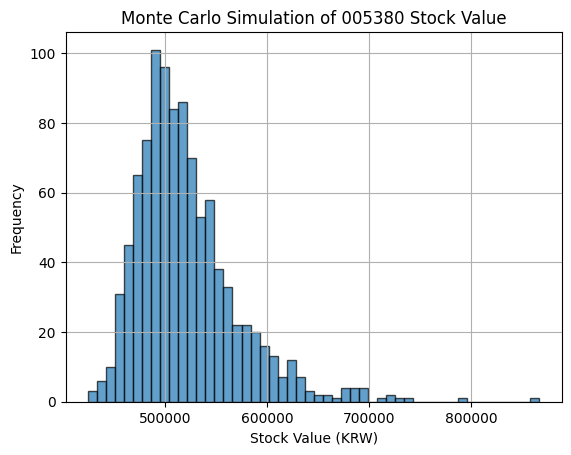

Mean Stock Value: 520689.67 KRW
Median Stock Value: 511466.80 KRW
Standard Deviation of Stock Value: 49803.05 KRW


,Stock Value
0,501844.266630
1,514276.843472
2,465743.313847
3,453404.165552
4,517767.843725
...,...
995,496143.159737
996,510470.233122
997,585522.562839
998,485456.128501


In [14]:
# Step4: DCF
asset1 = DCF(table, forecast, wacc, company)
asset1.pv_FCFF()
asset1.TV()
asset1.NOA_IBD(table)
stockvalue, table = asset1.EV()
asset1.monte_carlo_simulation()

In [ ]:
'''
import time

def checkTime(func):
    def new_func(*args):
        print("\n------------------------------------------------")
        start = time.time()
        func(*args)
        print("\n실행시간:",time.time()-start)
        print("------------------------------------------------\n")
    return new_func

@checkTime
def do_valuation():
    #try:
    # Step1 : loading F/S
    FS1_tables = load_FS()
    company = FS1_tables[0]
    IS = FS1_tables[1]
    BS = FS1_tables[2]
    CF = FS1_tables[3]

    # Preprocessing
    asset1 = step1(company, IS, BS, CF)
    tax = asset1.Basic_IS()
    asset1.Basic_CF()
    asset1.Dnwc()
    asset1.FCFF()
    fcff_table = asset1.mktable()

    # Step2 : Forecasting
    asset1 = step2(fcff_table, tax)
    asset1.ratios()
    asset1.Assume()
    forecast = asset1.forecast()

    # Step3 : WACC
    asset1 = WACC(company, BS, tax)
    asset1.risk_free_rate()
    asset1.market_risk_premium()
    asset1.beta()
    asset1.cost_debt()
    wacc = asset1.wacc()

    # Step4: DCF
    asset1 = DCF(forecast, wacc, company)
    asset1.pv_FCFF()
    asset1.TV()
    asset1.NOA_IBD(BS)
    stockvalue, table = asset1.EV()
    
    # Step5: Basic Analysis
    asset1 = analysis(company, stockvalue, BS, forecast, table)
    asset1.today_stockprice()
    asset1.visualization()
    cons = asset1.concensus()
    asset1.advise()

    # Step6: MonteCarlo Simulation --> terminal value를 확률변수로 두고 해보자

       
    #except:
        #print("\n데이터를 불러오는데 문제가 있습니다. 보통 필요한 정보가 누락된 경우에 발생합니다가 있습니다. 혹은 종목 코드를 다시 입력해보십시오.")
    
   
if __name__ == "__main__":
    do_valuation()
'''

'\nimport time\n\ndef checkTime(func):\n    def new_func(*args):\n        print("\n------------------------------------------------")\n        start = time.time()\n        func(*args)\n        print("\n실행시간:",time.time()-start)\n        print("------------------------------------------------\n")\n    return new_func\n\n@checkTime\ndef do_valuation():\n    #try:\n    # Step1 : loading F/S\n    FS1_tables = load_FS()\n    company = FS1_tables[0]\n    IS = FS1_tables[1]\n    BS = FS1_tables[2]\n    CF = FS1_tables[3]\n\n    # Preprocessing\n    asset1 = step1(company, IS, BS, CF)\n    tax = asset1.Basic_IS()\n    asset1.Basic_CF()\n    asset1.Dnwc()\n    asset1.FCFF()\n    fcff_table = asset1.mktable()\n\n    # Step2 : Forecasting\n    asset1 = step2(fcff_table, tax)\n    asset1.ratios()\n    asset1.Assume()\n    forecast = asset1.forecast()\n\n    # Step3 : WACC\n    asset1 = WACC(company, BS, tax)\n    asset1.risk_free_rate()\n    asset1.market_risk_premium()\n    asset1.beta()\n    ass